In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand, seed
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import make_blobs, make_circles, make_moons
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns

sns.set_style('white')
seed(42)

# #9b59b6: purple-400 / #3498db: blue-600 / #95a5a6: blue-grey-300 / #e74c3c: red
# #34495e: blue-grey-800 / #2ecc71: green-400-accent
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cmap = ListedColormap(sns.color_palette(flatui))

In [2]:
# Generate Synthetic Datasets
n_samples = 1500
random_state = 170
blobs = make_blobs(n_samples=n_samples, random_state=random_state)
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples,  noise=.05)
uniform = rand(n_samples, 2), None
X, y = make_blobs(n_samples=n_samples,  random_state=random_state)
elongated = X.dot([[0.6, -0.6], [-0.4, 0.8]]), y
varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
default_params = {'quantile': .3, 'eps': .2, 'damping': .9, 'preference': -200, 'n_neighbors': 10,
                  'n_clusters': 3}
datasets = [('Standard Normal', blobs, {}),
            ('Various Normal', varied, {'eps': .18, 'n_neighbors': 2}),
            ('Anisotropic Normal', elongated, {'eps': .15, 'n_neighbors': 2}),
            ('Uniform', uniform, {}),
            ('Circles', noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2}),
            ('Moons', noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2})]

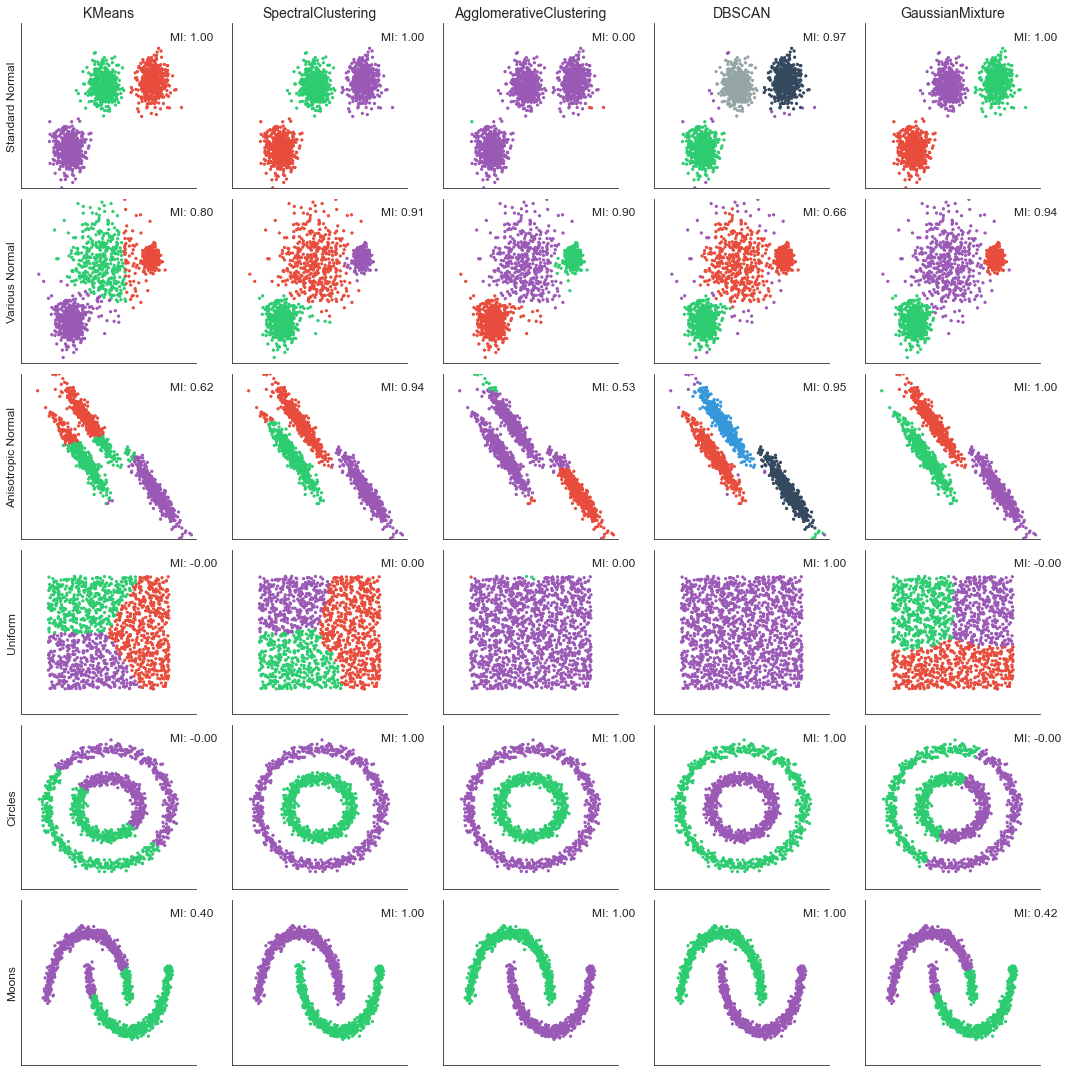

In [6]:
# Plot Cluster Algorithm Results
fig, axes = plt.subplots(figsize=(15, 15), ncols=5, nrows=len(datasets), sharey=True, sharex=True)

plt.setp(axes, xticks=[], yticks=[], xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

for d, (dataset_label, dataset, algo_params) in enumerate(datasets):
    params = default_params.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    kmeans = KMeans(n_clusters=params['n_clusters'])

    spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',
                                  affinity='nearest_neighbors')

    dbscan = DBSCAN(eps=params['eps'])
    average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock",
                                              n_clusters=params['n_clusters'], connectivity=connectivity)

    gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (('KMeans', kmeans), ('SpectralClustering', spectral),
                             ('AgglomerativeClustering', average_linkage), ('DBSCAN', dbscan),
                             ('GaussianMixture', gmm))

    for a, (name, algorithm) in enumerate(clustering_algorithms):

        if name == 'GaussianMixture':
            algorithm.fit(X)
            y_pred = algorithm.predict(X)
        else:
            y_pred = algorithm.fit_predict(X)

        axes[d, a].scatter(X[:, 0], X[:, 1], s=5, c=y_pred, cmap=cmap)

        if d == 0:
            axes[d, a].set_title(name, size=14)
        if a == 0:
            axes[d, a].set_ylabel(dataset_label, size=12)

        if y is None:
            y = [.5] * n_samples
        mi = adjusted_mutual_info_score(labels_pred=y_pred, labels_true=y)
        axes[d, a].text(0.85, 0.9, f'MI: {mi:.2f}', transform=axes[d, a].transAxes, fontsize=12)
        axes[d, a].axes.get_xaxis().set_visible(False)

sns.despine()
fig.tight_layout()